In [1]:
# check GPU
!nvidia-smi

Sun Dec  8 04:04:57 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    35W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install -q kaggle

In [0]:
from google.colab import files

In [4]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!echo '{"username":"karentree","key":"ff57b9d030d708de9af1a8da9558d6df"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d karentree/artchanllage-genre-classification

 99% 2.35G/2.36G [00:17<00:00, 170MB/s]
100% 2.36G/2.36G [00:17<00:00, 147MB/s]


In [7]:
!unzip artchanllage-genre-classification.zip

Archive:  artchanllage-genre-classification.zip
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_1.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_10.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_11.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_12.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_13.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_14.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_15.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_16.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_17.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_18.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_19.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_2.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_2

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.callbacks import *
from keras.initializers import *
from keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

Using TensorFlow backend.


In [0]:
os.remove('/content/genre/Northern_Renaissance/Northern_Renaissance_11.jpg')

In [10]:
# read csv
artists_unique = pd.read_csv("/content/artists_unique.csv")
artists_unique.head()

,Unnamed: 0,name,years,genre,nationality,paintings,number_of_genre,underscore
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,['Italian'],193,1,Amedeo_Modigliani
1,3,Claude Monet,1840 - 1926,Impressionism,['French'],73,1,Claude_Monet
2,5,Salvador Dali,1904 - 1989,Surrealism,['Spanish'],139,1,Salvador_Dali
3,7,Andrei Rublev,1360 - 1430,Byzantine_Art,['Russian'],99,1,Andrei_Rublev
4,8,Vincent van Gogh,1853 – 1890,Post-Impressionism,['Dutch'],877,1,Vincent_van_Gogh


In [0]:
genre_series = artists_unique.groupby('genre')['paintings'].sum()
genre_df = pd.DataFrame(genre_series, columns=['paintings'])

In [0]:
#genre_df = genre_df.reset_index()
# get genre_df
genre_df['genre_weight'] = genre_df['paintings'] /(genre_df.shape[0] * genre_df['paintings'])

In [13]:
# top five genres
genre_df['paintings'].sort_values(ascending=False)[:5]

genre
Northern_Renaissance    1689
Impressionism           1591
Post-Impressionism      1570
Realism                 1478
Romanticism             1331
Name: paintings, dtype: int64

In [0]:
genre_top5 = genre_df['paintings'].sort_values(ascending=False)[:5].index

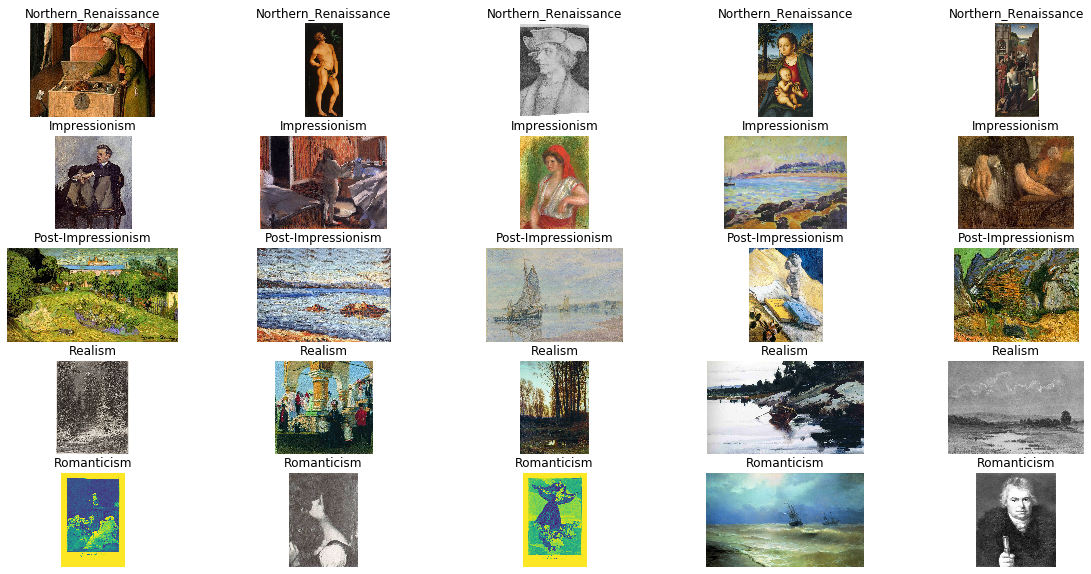

In [15]:
n = 5
fig, axes = plt.subplots(5, n, figsize=(20,10))

genre_dir = '/content/genre/'
for i, genre in enumerate(genre_top5):
  for j in range(n):
    random_image_file = random.choice(os.listdir(genre_dir+genre))
    #print(random_image_file)
    image = plt.imread(os.path.join(genre_dir,genre,random_image_file))
    axes[i][j].imshow(image)
    axes[i][j].axis('off')
    axes[i][j].set_title(genre)
plt.show()

# **Data Augmentation**

In [0]:
# Initialize the data augmenter as an empty image data generator
aug = ImageDataGenerator(validation_split=0.2,
                         rescale=1./255.,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True)

In [0]:
genre_series = genre_series[genre_series > 200]

In [18]:
genre_series.index.to_list()

['Art_Nouveau',
 'Baroque',
 'Cubism',
 'Early_Renaissance',
 'Expressionism',
 'High_Renaissance',
 'Impressionism',
 'Northern_Renaissance',
 'Post-Impressionism',
 'Primitivism',
 'Realism',
 'Romanticism',
 'Socialist_Realism',
 'Surrealism',
 'Symbolism']

In [19]:
batch_size = 12
train_input_shape = (224, 224, 3)

train_generator = aug.flow_from_directory(directory=genre_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=genre_series.index.to_list()
                                                   )
valid_generator = aug.flow_from_directory(directory=genre_dir,
                                               class_mode='categorical',
                                               target_size=train_input_shape[0:2],
                                               batch_size=batch_size,
                                               subset="validation",
                                               shuffle=True,
                                               classes=genre_series.index.to_list())
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 9801 images belonging to 15 classes.
Found 2443 images belonging to 15 classes.
Total number of batches = 816 and 203




# **Model Built**

In [0]:
np.random.seed(1000)
n_class = genre_series.shape[0]

def alexnet_model(img_shape=(224, 224, 3), n_classes=n_class, l2_reg=0.,
	weights=None):

	# Initialize model
	alexnet = Sequential()

	# Layer 1
	alexnet.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), input_shape=img_shape,
						padding='valid'))
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(3, 3),strides=(2,2)))
	# Batch Normalization before passing it to the next layer
	alexnet.add(BatchNormalization())

	# Layer 2
	alexnet.add(Conv2D(256, (5, 5), padding='same'))
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(3, 3),strides=(2,2)))
	alexnet.add(BatchNormalization())

	# Layer 3
	alexnet.add(Conv2D(384, (3, 3), padding='same',strides=(1,1)))
	alexnet.add(Activation('relu'))
	#alexnet.add(MaxPooling2D(pool_size=(2, 2)))
	alexnet.add(BatchNormalization())

	# Layer 4
	alexnet.add(Conv2D(384, (3, 3), padding='same',strides=(1,1)))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(BatchNormalization())

	# Layer 5
	alexnet.add(Conv2D(256, (3, 3), padding='same',strides=(1,1)))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
	alexnet.add(BatchNormalization())

	# Layer 6
	alexnet.add(Flatten())
	alexnet.add(Dense(3072))
	#alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))


	# Layer 7
	alexnet.add(Dense(3072))
	#alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 8
	alexnet.add(Dense(n_classes))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('softmax'))	

	return alexnet


In [22]:
model = alexnet_model()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [23]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [0]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [25]:
# Train the model - all layers
n_epoch = 30

from keras.callbacks import CSVLogger
csv_logger = CSVLogger("Alexnet_history_genre_200_log.csv", append=True)
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr,csv_logger],
                              use_multiprocessing=True,
                              workers=16
                             )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
816/816 [==============================] - 300s 367ms/step - loss: 2.4987 - acc: 0.2000 - val_loss: 3.1655 - val_acc: 0.1186
Epoch 2/30
816/816 [==============================] - 292s 358ms/step - loss: 2.2825 - acc: 0.2598 - val_loss: 2.3424 - val_acc: 0.2279
Epoch 3/30
816/816 [==============================] - 298s 366ms/step - loss: 2.2008 - acc: 0.2875 - val_loss: 2.3598 - val_acc: 0.2353
Epoch 4/30
816/816 [==============================] - 298s 365ms/step - loss: 2.1401 - acc: 0.3076 - val_loss: 2.2051 - val_acc: 0.3007
Epoch 5/30
816/816 [==============================] - 299s 367ms/step - loss: 2.1030 - acc: 0.3219 - val_loss: 2.5689 - val_acc: 0.1991
Epoch 6/30
816/816 [==============================] - 307s 377ms/step - loss: 2.0526 - acc: 0.3418 - val_loss: 2.0553 - val_acc: 0.3340
Epoch 7/30
816/816 [==============================] - 293s 359ms/step - loss: 2.0328 - acc: 0.3458 - val_loss: 2.2033 - val_acc: 0.2633
Epoch 8/30
816/816 [============================

In [26]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp /content/Alexnet_history_genre_200_log.csv /content/gdrive/My\ Drive/

In [0]:
from keras.models import load_model

path = "/content/gdrive/My Drive/alexnet_model_genre_200.h5" 
model.save(path)


In [0]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

n_classes = genre_series.shape[0]
tick_labels = genre_series.index.to_list()

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=tick_labels))


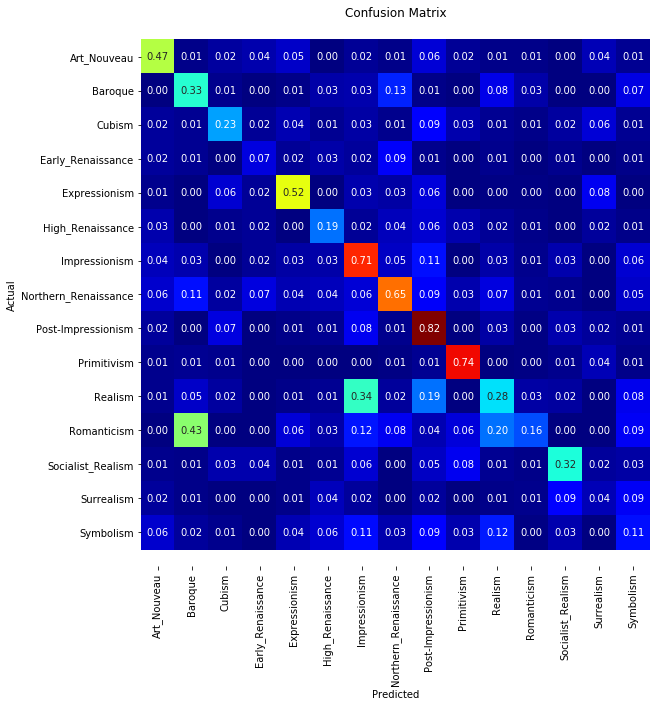

Classification Report:
                      precision    recall  f1-score   support

         Art_Nouveau       0.59      0.47      0.52        90
             Baroque       0.32      0.33      0.32       150
              Cubism       0.45      0.23      0.31        86
   Early_Renaissance       0.25      0.07      0.11        57
       Expressionism       0.62      0.52      0.56       110
    High_Renaissance       0.37      0.19      0.25        67
       Impressionism       0.43      0.71      0.54       319
Northern_Renaissance       0.56      0.65      0.60       334
  Post-Impressionism       0.48      0.82      0.61       311
         Primitivism       0.72      0.74      0.73        62
             Realism       0.32      0.28      0.30       292
         Romanticism       0.54      0.16      0.25       267
   Socialist_Realism       0.54      0.32      0.40        88
          Surrealism       0.12      0.04      0.06        48
           Symbolism       0.18      0.11     

In [33]:
showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

Text(0, 0.5, 'accuracy')

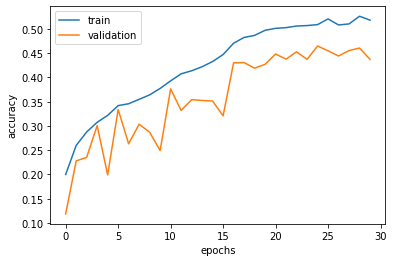

In [34]:
import matplotlib.pyplot as plt

plt.plot(history1.history['acc'], label='train')
plt.plot(history1.history['val_acc'], label='validation')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')